<a href="https://colab.research.google.com/github/ndb796/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/blob/main/PyTorch_FGSM_Adversarial_Attack_using_MNIST_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Load Required Libraries</b>

In [1]:
# load required PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [2]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### <b>Image Visualization</b>

In [3]:
# load an image visualization library
import matplotlib.pyplot as plt
import PIL

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [4]:
# show torch.Tensor image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0) # [1, H, W]
    image = transforms.ToPILImage()(image)
    # show an image whose values are between [0, 1]
    plt.imshow(image)
    plt.show()

#### <b>Load Pre-trained Classification Model</b>

In [5]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EaLEiaWty0VKnJlfSHZwmkoBRMKuKa99rtR1j0m26l8MjA?download=1 -O mnist_model.pth

--2021-03-07 21:05:08--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EaLEiaWty0VKnJlfSHZwmkoBRMKuKa99rtR1j0m26l8MjA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/CSED703G_LeNet_MNIST.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FYUxFaWFXdHkwVktuSmxmU0had21rb0JSTUt1S2E5OXJ0UjFqMG0yNmw4TWpBP3J0aW1lPVNIMFpzYXpoMkVn [following]
--2021-03-07 21:05:09--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/CSED703G_LeNet_MNIST.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FYUxFaWFXdHkwVktuSmxmU0h

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(50 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), (2, 2))
        x = F.max_pool2d(self.conv2(x), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [7]:
model = LeNet()
model = model.to(device)
checkpoint = torch.load('./mnist_model.pth')
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

#### <b>Load Test Dataset</b>

In [10]:
from six.moves import urllib

opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [12]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

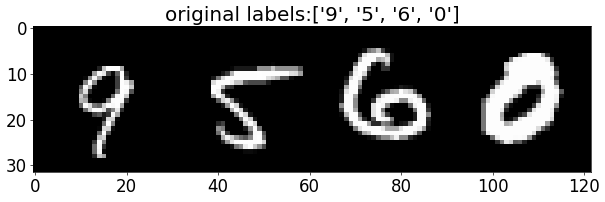

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 9 (9)
Image #2: 5 (5)
Image #3: 6 (6)
Image #4: 0 (0)


In [13]:
import numpy as np


def imshow_batch(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of validation image
iterator = iter(test_dataloader)

# visualize a batch of validation image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels:' + str([class_names[x] for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, label in enumerate(classes[:4]):
    print(f'Image #{i + 1}: {class_names[label]} ({label})')

#### <b>Test Phase</b>

[Prediction Result Examples]


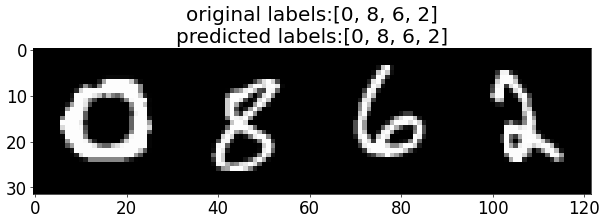

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 0 (0)
Image #1: 8 (8)
Image #1: 6 (6)
Image #1: 2 (2)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 0 (0)
Image #1: 8 (8)
Image #1: 6 (6)
Image #1: 2 (2)


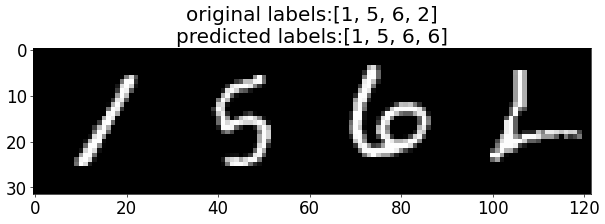

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 1 (1)
Image #1: 5 (5)
Image #1: 6 (6)
Image #1: 2 (2)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 1 (1)
Image #1: 5 (5)
Image #1: 6 (6)
Image #1: 6 (6)
[Validation] Loss: 0.0005 Accuracy: 98.9900% Time elapsed: 1.4581s (total 10000 images)


In [14]:
import time

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(labels[:4]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(preds[:4]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(labels[4:8]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(preds[4:8]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

#### <b>Prepare Adversarial Attack Libraries</b>

In [16]:
!pip install foolbox
!pip install advertorch

In [17]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

#### <b>Adversarial Attack Example 1</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 1 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([1, 28, 28])
[Prediction Result Examples]


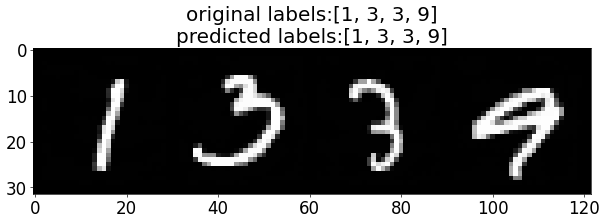

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 1 (1)
Image #1: 3 (3)
Image #1: 3 (3)
Image #1: 9 (9)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 1 (1)
Image #1: 3 (3)
Image #1: 3 (3)
Image #1: 9 (9)


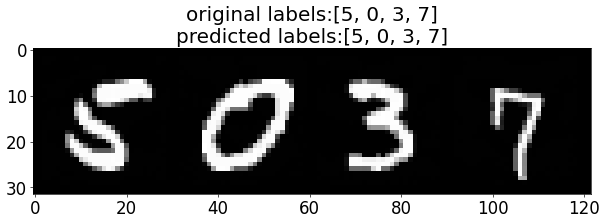

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 5 (5)
Image #1: 0 (0)
Image #1: 3 (3)
Image #1: 7 (7)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 5 (5)
Image #1: 0 (0)
Image #1: 3 (3)
Image #1: 7 (7)
[Step #0] Loss: 0.0013 Accuracy: 98.4375% Time elapsed: 0.4696s (total 64 images)
[Step #10] Loss: 0.0007 Accuracy: 98.4375% Time elapsed: 0.5610s (total 704 images)
[Step #20] Loss: 0.0006 Accuracy: 98.4375% Time elapsed: 0.6386s (total 1344 images)
[Step #30] Loss: 0.0007 Accuracy: 98.3871% Time elapsed: 0.7153s (total 1984 images)
[Step #40] Loss: 0.0006 Accuracy: 98.6662% Time elapsed: 0.8012s (total 2624 images)
[Step #50] Loss: 0.0006 Accuracy: 98.7439% Time elapsed: 0.8753s (total 3264 images)
[Step #60] Loss: 0.0006 Accuracy: 98.7961% Time elapsed: 0.9550s (total 3904 images)
[Step #70] Loss: 0.0006 Accuracy: 98.8336% Time elapsed: 1.0480s (total 4544 images)
[Step #80] Loss: 0.0006 Accuracy: 98.8812% Time elapsed: 1.1250s (total 5184 images)
[Step #90] Loss: 0.0006 Ac

In [18]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=1/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Adversarial Attack Example 2</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 2 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([1, 28, 28])
[Prediction Result Examples]


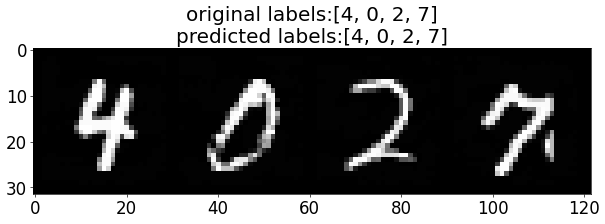

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 4 (4)
Image #1: 0 (0)
Image #1: 2 (2)
Image #1: 7 (7)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 4 (4)
Image #1: 0 (0)
Image #1: 2 (2)
Image #1: 7 (7)


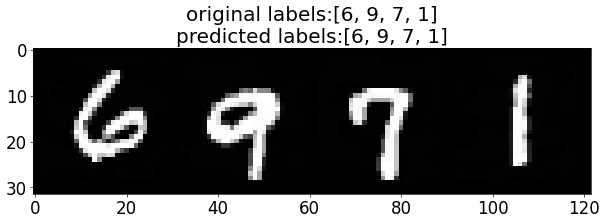

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 6 (6)
Image #1: 9 (9)
Image #1: 7 (7)
Image #1: 1 (1)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 6 (6)
Image #1: 9 (9)
Image #1: 7 (7)
Image #1: 1 (1)
[Step #0] Loss: 0.0001 Accuracy: 100.0000% Time elapsed: 0.4723s (total 64 images)
[Step #10] Loss: 0.0012 Accuracy: 98.0114% Time elapsed: 0.5583s (total 704 images)
[Step #20] Loss: 0.0007 Accuracy: 98.5119% Time elapsed: 0.6433s (total 1344 images)
[Step #30] Loss: 0.0007 Accuracy: 98.5383% Time elapsed: 0.7194s (total 1984 images)
[Step #40] Loss: 0.0007 Accuracy: 98.6662% Time elapsed: 0.8031s (total 2624 images)
[Step #50] Loss: 0.0006 Accuracy: 98.7439% Time elapsed: 0.8804s (total 3264 images)
[Step #60] Loss: 0.0006 Accuracy: 98.7449% Time elapsed: 0.9588s (total 3904 images)
[Step #70] Loss: 0.0006 Accuracy: 98.7016% Time elapsed: 1.0404s (total 4544 images)
[Step #80] Loss: 0.0007 Accuracy: 98.6497% Time elapsed: 1.1228s (total 5184 images)
[Step #90] Loss: 0.0007 A

In [19]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=2/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Adversarial Attack Example 3</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 4 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([1, 28, 28])
[Prediction Result Examples]


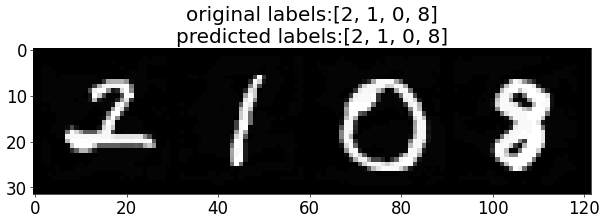

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 2 (2)
Image #1: 1 (1)
Image #1: 0 (0)
Image #1: 8 (8)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 2 (2)
Image #1: 1 (1)
Image #1: 0 (0)
Image #1: 8 (8)


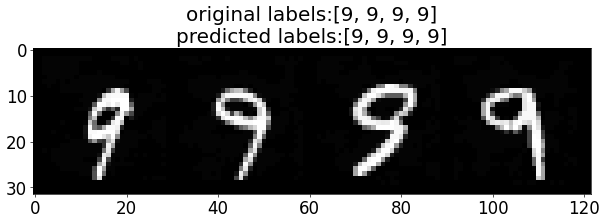

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 9 (9)
Image #1: 9 (9)
Image #1: 9 (9)
Image #1: 9 (9)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 9 (9)
Image #1: 9 (9)
Image #1: 9 (9)
Image #1: 9 (9)
[Step #0] Loss: 0.0005 Accuracy: 98.4375% Time elapsed: 0.4185s (total 64 images)
[Step #10] Loss: 0.0010 Accuracy: 97.5852% Time elapsed: 0.4972s (total 704 images)
[Step #20] Loss: 0.0010 Accuracy: 97.8423% Time elapsed: 0.5806s (total 1344 images)
[Step #30] Loss: 0.0010 Accuracy: 97.7823% Time elapsed: 0.6570s (total 1984 images)
[Step #40] Loss: 0.0009 Accuracy: 97.8659% Time elapsed: 0.7475s (total 2624 images)
[Step #50] Loss: 0.0010 Accuracy: 97.9167% Time elapsed: 0.8251s (total 3264 images)
[Step #60] Loss: 0.0010 Accuracy: 97.9764% Time elapsed: 0.9061s (total 3904 images)
[Step #70] Loss: 0.0009 Accuracy: 98.0634% Time elapsed: 0.9862s (total 4544 images)
[Step #80] Loss: 0.0009 Accuracy: 98.0517% Time elapsed: 1.0604s (total 5184 images)
[Step #90] Loss: 0.0009 Ac

In [20]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=4/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Adversarial Attack Example 4</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 8 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([1, 28, 28])
[Prediction Result Examples]


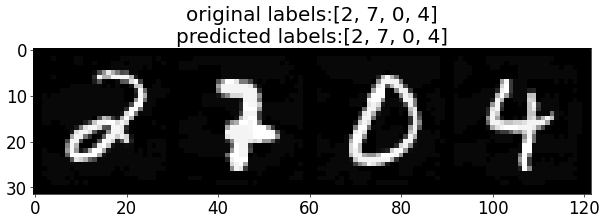

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 2 (2)
Image #1: 7 (7)
Image #1: 0 (0)
Image #1: 4 (4)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 2 (2)
Image #1: 7 (7)
Image #1: 0 (0)
Image #1: 4 (4)


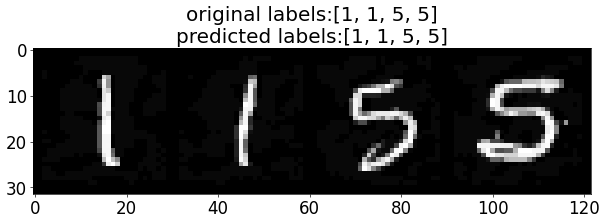

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 1 (1)
Image #1: 1 (1)
Image #1: 5 (5)
Image #1: 5 (5)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 1 (1)
Image #1: 1 (1)
Image #1: 5 (5)
Image #1: 5 (5)
[Step #0] Loss: 0.0016 Accuracy: 96.8750% Time elapsed: 0.4192s (total 64 images)
[Step #10] Loss: 0.0017 Accuracy: 97.0171% Time elapsed: 0.5041s (total 704 images)
[Step #20] Loss: 0.0016 Accuracy: 97.0982% Time elapsed: 0.5770s (total 1344 images)
[Step #30] Loss: 0.0016 Accuracy: 97.0766% Time elapsed: 0.6558s (total 1984 images)
[Step #40] Loss: 0.0014 Accuracy: 97.3323% Time elapsed: 0.7330s (total 2624 images)
[Step #50] Loss: 0.0015 Accuracy: 97.2427% Time elapsed: 0.8081s (total 3264 images)
[Step #60] Loss: 0.0015 Accuracy: 97.1311% Time elapsed: 0.8883s (total 3904 images)
[Step #70] Loss: 0.0015 Accuracy: 97.0511% Time elapsed: 0.9644s (total 4544 images)
[Step #80] Loss: 0.0015 Accuracy: 97.0872% Time elapsed: 1.0379s (total 5184 images)
[Step #90] Loss: 0.0015 Ac

In [21]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=8/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Adversarial Attack Example 5</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 16 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([1, 28, 28])
[Prediction Result Examples]


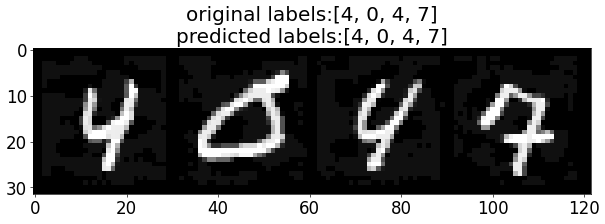

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 4 (4)
Image #1: 0 (0)
Image #1: 4 (4)
Image #1: 7 (7)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 4 (4)
Image #1: 0 (0)
Image #1: 4 (4)
Image #1: 7 (7)


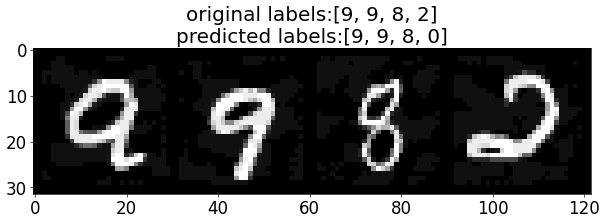

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 9 (9)
Image #1: 9 (9)
Image #1: 8 (8)
Image #1: 2 (2)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 9 (9)
Image #1: 9 (9)
Image #1: 8 (8)
Image #1: 0 (0)
[Step #0] Loss: 0.0050 Accuracy: 81.2500% Time elapsed: 0.4292s (total 64 images)
[Step #10] Loss: 0.0040 Accuracy: 90.3409% Time elapsed: 0.5102s (total 704 images)
[Step #20] Loss: 0.0042 Accuracy: 90.9226% Time elapsed: 0.5909s (total 1344 images)
[Step #30] Loss: 0.0040 Accuracy: 91.2298% Time elapsed: 0.6658s (total 1984 images)
[Step #40] Loss: 0.0040 Accuracy: 91.3491% Time elapsed: 0.7560s (total 2624 images)
[Step #50] Loss: 0.0039 Accuracy: 91.5748% Time elapsed: 0.8352s (total 3264 images)
[Step #60] Loss: 0.0040 Accuracy: 91.4447% Time elapsed: 0.9130s (total 3904 images)
[Step #70] Loss: 0.0042 Accuracy: 91.3732% Time elapsed: 0.9910s (total 4544 images)
[Step #80] Loss: 0.0042 Accuracy: 91.5316% Time elapsed: 1.0698s (total 5184 images)
[Step #90] Loss: 0.0043 Ac

In [22]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=16/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Adversarial Attack Example 6</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 32 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([1, 28, 28])
[Prediction Result Examples]


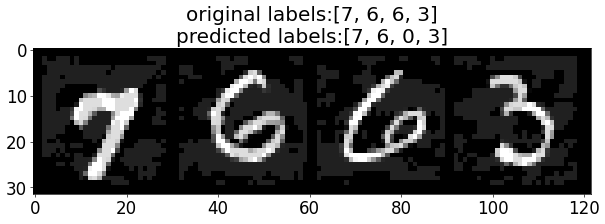

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 7 (7)
Image #1: 6 (6)
Image #1: 6 (6)
Image #1: 3 (3)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 7 (7)
Image #1: 6 (6)
Image #1: 0 (0)
Image #1: 3 (3)


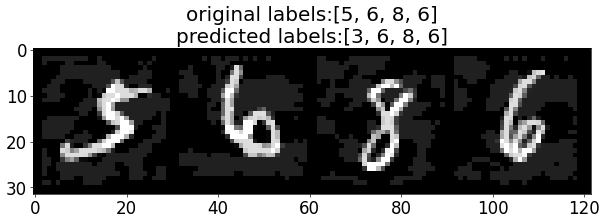

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 5 (5)
Image #1: 6 (6)
Image #1: 8 (8)
Image #1: 6 (6)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 3 (3)
Image #1: 6 (6)
Image #1: 8 (8)
Image #1: 6 (6)
[Step #0] Loss: 0.0245 Accuracy: 65.6250% Time elapsed: 0.4285s (total 64 images)
[Step #10] Loss: 0.0221 Accuracy: 62.9261% Time elapsed: 0.5133s (total 704 images)
[Step #20] Loss: 0.0221 Accuracy: 61.1607% Time elapsed: 0.5974s (total 1344 images)
[Step #30] Loss: 0.0212 Accuracy: 62.5000% Time elapsed: 0.6855s (total 1984 images)
[Step #40] Loss: 0.0209 Accuracy: 62.8049% Time elapsed: 0.7632s (total 2624 images)
[Step #50] Loss: 0.0213 Accuracy: 62.0711% Time elapsed: 0.8407s (total 3264 images)
[Step #60] Loss: 0.0212 Accuracy: 62.2951% Time elapsed: 0.9261s (total 3904 images)
[Step #70] Loss: 0.0213 Accuracy: 62.3460% Time elapsed: 1.0125s (total 4544 images)
[Step #80] Loss: 0.0217 Accuracy: 61.9792% Time elapsed: 1.0988s (total 5184 images)
[Step #90] Loss: 0.0217 Ac

In [23]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=32/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Comparison with Foolbox</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 32 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([1, 28, 28])
[Prediction Result Examples]


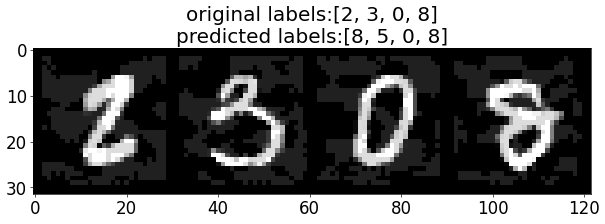

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 2 (2)
Image #1: 3 (3)
Image #1: 0 (0)
Image #1: 8 (8)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 8 (8)
Image #1: 5 (5)
Image #1: 0 (0)
Image #1: 8 (8)


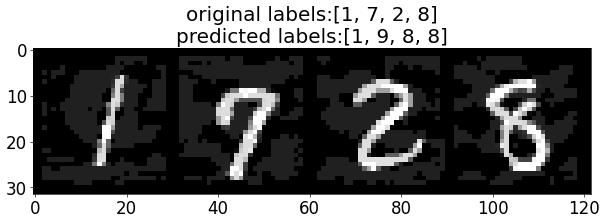

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 1 (1)
Image #1: 7 (7)
Image #1: 2 (2)
Image #1: 8 (8)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: 1 (1)
Image #1: 9 (9)
Image #1: 8 (8)
Image #1: 8 (8)
[Step #0] Loss: 0.0180 Accuracy: 73.4375% Time elapsed: 0.4943s (total 64 images)
[Step #10] Loss: 0.0192 Accuracy: 62.6421% Time elapsed: 0.5913s (total 704 images)
[Step #20] Loss: 0.0195 Accuracy: 62.7232% Time elapsed: 0.6812s (total 1344 images)
[Step #30] Loss: 0.0202 Accuracy: 61.9456% Time elapsed: 0.7730s (total 1984 images)
[Step #40] Loss: 0.0206 Accuracy: 61.9283% Time elapsed: 0.8589s (total 2624 images)
[Step #50] Loss: 0.0206 Accuracy: 62.0711% Time elapsed: 0.9373s (total 3264 images)
[Step #60] Loss: 0.0208 Accuracy: 62.1670% Time elapsed: 1.0392s (total 3904 images)
[Step #70] Loss: 0.0211 Accuracy: 61.7958% Time elapsed: 1.1260s (total 4544 images)
[Step #80] Loss: 0.0210 Accuracy: 61.8056% Time elapsed: 1.2090s (total 5184 images)
[Step #90] Loss: 0.0212 Ac

In [24]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.LinfFastGradientAttack()

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    _, adv_untargeted, _ = attack(fmodel, inputs, labels, epsilons=32/255) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))